In [1]:
from itertools import product
import torch
from torchvision.transforms import ToTensor
from torchvision import datasets
from pysr import PySRRegressor
from model import CNN
import pandas as pd
import numpy as np
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt

/home/croniev/Code/cysec/lib/python3.9/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


### Load Model and get Kernels

In [ ]:
cnn = CNN()
cnn.load_state_dict(torch.load('cnn.pt'))
print(cnn)

for name, param in cnn.named_parameters():
    if name == 'conv1.weight':
        print(f"amount of kernels of Conv1: {param.shape}")
        kernels1 = param
    if name == 'conv2.weight':
        print(f"amount of kernels of Conv2: {param.shape}")
print(f"kernels of first layer:\n{kernels1}")

### Load Dataset and get results

In [ ]:
test_data = datasets.MNIST(root='data', train=False, transform=ToTensor(),)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=20, shuffle=True, num_workers=1)
samples, labels = next(iter(test_loader))

cnn.eval()
with torch.no_grad():
    results = cnn(samples)

### Prepare Data for PySR and extract features
Extract the 5x5 submatrices (incl. padding) from images to use them as input

In [ ]:
# Take every image and split it into 5x5 submatrices => np.array.shape = (7840, 5, 5)
# 7840 <- 28 * 28 patches per image * 10 images (batch_size)
kernel_size = 5
X = None
for x in samples:
    x = torch.nn.functional.pad(input=x[0], pad=(2, 2, 2, 2), mode="constant", value=0)
    for i, j in np.ndindex((x.size()[0] - kernel_size + 1, x.size()[1] - kernel_size + 1)):
        slice = x[i:i + kernel_size, j:j + kernel_size]
        if X is None:
            # X = np.array([slice.numpy().flatten()])
            X = np.array([slice.numpy()])
        else:
            # X = np.concatenate((X, [slice.numpy().flatten()]))
            X = np.concatenate((X, [slice.numpy()]))

print(X.shape)

# Get the result for every 5x5 submatrix for each kernel => np.array.shape = (16, 7840)
# 16 <- amount of kernels in the first layer
y = results['relu1'].numpy().transpose(1, 0, 2, 3).reshape(16, X.shape[0])
print(y.shape)

#### Discrete Cosine Transform (DCT, Fourier Transform)
Get DCT features of image, only keep low frequencies.

In [ ]:
def dct2(m):
    return dct(dct(m.T, norm='ortho').T, norm='ortho')

Xdct = np.array(list(map(dct2, X)))
dct_filter_param = 3
Xdct_filtered = np.array(list(map(lambda m: m[:dct_filter_param, :dct_filter_param], Xdct)))
print(Xdct_filtered.shape)

Figures of corresponding frequencies

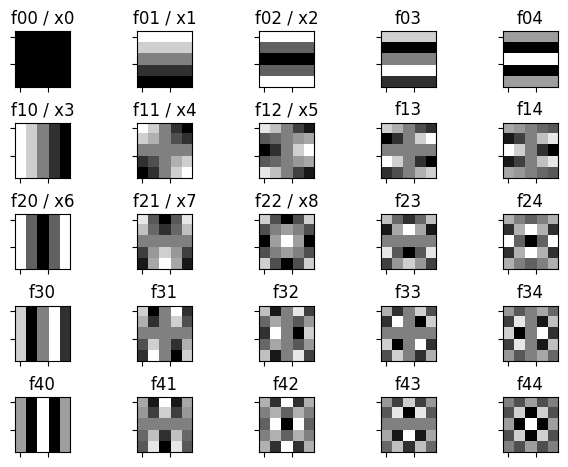

In [3]:
fig, axs = plt.subplots(5,5)
fig.tight_layout(h_pad=0.5, w_pad=0)
for i, j in list(product(range(5), range(5))):
    img = np.zeros((5, 5))
    img[i, j] = 1
    axs[i, j].imshow(idct(idct(img, norm='ortho').T, norm='ortho'), cmap='gray')
    axs[i, j].set_yticklabels([])
    axs[i, j].set_xticklabels([])
    if i < 3 and j < 3:
        axs[i, j].set_title(f"f{i}{j} / x{3*i + j}")
    else:
        axs[i, j].set_title(f"f{i}{j}")

### Symbolic Regression

In [ ]:
def newPySRRegressor():
    return PySRRegressor(
        niterations=40,
        binary_operators=["+", "*", "-", "/"],
        unary_operators=[
            "cos",
            "exp",
            "sin",
            "square",
            "cube",
            "inv(x) = 1/x",  # Julia syntax
        ],
        extra_sympy_mappings={"inv": lambda x: 1 / x},  # Sympy syntax
        elementwise_loss="loss(prediction, target) = (prediction - target)^2",  # Julia syntax
        warm_start=False,
        verbosity=0,
        temp_equation_file=True,
    )

#### Over the first kernel

In [ ]:
regr_first_kernel = newPySRRegressor()
regr_first_kernel.fit(Xdct_filtered.reshape(X.shape[0], dct_filter_param**2), y[0])  # Input data coded for position and summed

In [ ]:
print(regr_first_kernel.equations_['lambda_format'])
f = regr_first_kernel.equations_['lambda_format'][4]
print(f(np.array(range(9))))

#### Over all 16 Kernels

In [ ]:
regr_all_kernels = pd.DataFrame()
regr_all_kernels.index.names = ['complexity']
for i in range(16):
    regr = newPySRRegressor()
    regr.fit(Xdct_filtered.reshape((X.shape[0], dct_filter_param**2)), y[i])  # Input data as is
    # print(regr.equations_)
    regr_all_kernels.insert(loc=i, column=f'Kernel {i}', value=regr.equations_['equation'])
    print(f"Done with Kernel {i} | {(i+1)/16 * 100}%")

print(regr_all_kernels)

In [ ]:
regr_all_kernels.to_csv('results_dct_filter3_allkernels.csv')

#### Over the first kernel multiple times (Stability check)

In [ ]:
regr_stability = pd.DataFrame()
regr_stability.index.names = ['complexity']
for i in range(10):
    regr = newPySRRegressor()
    regr.fit(Xdct_filtered.reshape((X.shape[0], dct_filter_param**2)), y[0])
    # print(regr.equations_)
    regr_stability.insert(loc=i, column=f'Iteration {i}', value=regr.equations_['equation'])
    # print(regr_stability)
    print(f"Done with Iteration {i} | {(i+1)/10 * 100}%")

In [ ]:
regr_stability.to_csv('results_dct_filter3_stability.csv')